# HAR-UDA

unsupervised cross subjects domain adaptation for human activity recognition based on CycleGAN

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2DTranspose, Lambda

import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import collections
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import os
import time

import gc

print(tf.__version__)

2.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
har_uda_root = '/content/gdrive/My Drive/har-uda/'
data_path = har_uda_root+'data/'
ckp_path = har_uda_root+'checkpoints/'

### Load data

In [0]:
def load_data(sub_id):
    name_list = ['data_x_train', 'data_x_val', 'data_x_test', 'data_y_train', 'data_y_val', 'data_y_test']

    data = {}
    for name in name_list:
        save_path = data_path + name + '_{}.npy'.format(sub_id)
        data[name] = np.load(save_path)
    return data

def load_classifier(sub_id):
    model_path = ckp_path + 'classifier_{}.hdf5'.format(sub_id)
    model = tf.keras.models.load_model(model_path)
    return model

In [0]:
sub_11_data = load_data(11)
sub_16_data = load_data(16)
classifier_11 = load_classifier(11)
classifier_16 = load_classifier(16)

source_data = sub_11_data
target_data = sub_16_data
source_classifier = classifier_11
target_classifier = classifier_16

## CycleGAN

In [0]:
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    down_result = tf.keras.Sequential()
    down_result.add(
        tf.keras.layers.Conv1D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    )

    if apply_instancenorm:
        down_result.add(InstanceNormalization())

    down_result.add(tf.keras.layers.LeakyReLU())

    return down_result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    up_result = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: K.expand_dims(x, axis=2)),
        tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(size, 1), strides=(2, 1), padding='same', kernel_initializer=initializer, use_bias=False),
        tf.keras.layers.Lambda(lambda x: K.squeeze(x, axis=2))
    ])

    up_result.add(InstanceNormalization())

    if apply_dropout:
        up_result.add(tf.keras.layers.Dropout(0.5))

    up_result.add(tf.keras.layers.ReLU())

    return up_result

def resnet_block(filters, size, input_layer):
    initializer = tf.random_normal_initializer(0., 0.02)
    # first layer convolutional layer
    g = tf.keras.layers.Conv1D(filters, size, padding='same', kernel_initializer=initializer)(input_layer)
    g = InstanceNormalization()(g)
    g = tf.keras.layers.Activation('relu')(g)
    # second cnn
    g = tf.keras.layers.Conv1D(filters, size, padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization()(g)
    g = tf.keras.layers.Concatenate()([g, input_layer])
    return g

In [0]:
def Generator(input_shape=(128, 9), output_channels=9):
    inputs = tf.keras.layers.Input(shape=input_shape)

    down_stack = [
        downsample(8, 5, apply_instancenorm=False),  # (bs, 64, 8)
        downsample(16, 5),  # (bs, 32, 16)
        downsample(32, 5),  # (bs, 16, 32)
        downsample(32, 5),  # (bs, 8, 32)   
    ]

    up_stack = [
        upsample(32, 5, apply_dropout=True),  # (bs, 16, 64)
        upsample(16, 5),  # (bs, 32, 32)
        upsample(8, 5),  # (bs, 64, 16)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: K.expand_dims(x, axis=2)),
        tf.keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=(5, 1), strides=(2, 1), padding='same',  kernel_initializer=initializer, activation='tanh'),
        tf.keras.layers.Lambda(lambda x: K.squeeze(x, axis=2))
    ])

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    x = resnet_block(32, 5, input_layer=x)
    x = resnet_block(32, 5, input_layer=x)
    x = resnet_block(32, 5, input_layer=x)

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x) 

    return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def Discriminator(input_shape=(128, 9)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = inputs
    x = downsample(8, 5, apply_instancenorm=False)(x)  # (bs, 64, 8)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = downsample(16, 5)(x)  # (bs, 32, 16)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = downsample(32, 5)(x)  # (bs, 16, 32)
    x = downsample(32, 5)(x)  # (bs, 8, 32)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

define 2 generator and 2 discriminator for cyclegan

In [0]:
generator_s2t = Generator(input_shape=(128, 9), output_channels=9)
generator_t2s = Generator(input_shape=(128, 9), output_channels=9)

discriminator_s = Discriminator(input_shape=(128, 9))
discriminator_t = Discriminator(input_shape=(128, 9))

define loss function

In [0]:
LAMBDA = 10
crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real, disc_generated):
    real_loss = crossentropy(tf.ones_like(disc_real), disc_real)

    generated_loss = crossentropy(
        tf.zeros_like(disc_generated), disc_generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

    
def generator_loss(disc_generated):
    return crossentropy(tf.ones_like(disc_generated), disc_generated)


def calc_cycle_loss(real, cycled):
    loss1 = tf.reduce_mean(tf.abs(real - cycled))

    return LAMBDA * loss1


def identity_loss(real, same):
    loss = tf.reduce_mean(tf.abs(real - same))
    return LAMBDA * 0.5 * loss

In [0]:
generator_s2t_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_t2s_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_s_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_t_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Checkpoints

mount google drive to save checkpoints

In [0]:
checkpoint_path = "cyclegan/11and16"

ckpt_path = har_uda_root + checkpoint_path

ckpt = tf.train.Checkpoint(generator_s2t=generator_s2t,
                           generator_t2s=generator_t2s,
                           discriminator_s=discriminator_s,
                           discriminator_t=discriminator_t,
                           generator_s2t_optimizer=generator_s2t_optimizer,
                           generator_t2s_optimizer=generator_t2s_optimizer,
                           discriminator_s_optimizer=discriminator_s_optimizer,
                           discriminator_t_optimizer=discriminator_t_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [0]:
@tf.function
def train_step(real_s, real_t, epoch):
    with tf.GradientTape(persistent=True) as tape:
        fake_t = generator_s2t(real_s, training=True)
        cycled_s = generator_t2s(fake_t, training=True)

        fake_s = generator_t2s(real_t, training=True)
        cycled_t = generator_s2t(fake_s, training=True)

        same_s = generator_t2s(real_s, training=True)
        same_t = generator_s2t(real_t, training=True)

        disc_real_s = discriminator_s(real_s, training=True)
        disc_real_t = discriminator_t(real_t, training=True)

        disc_fake_s = discriminator_s(fake_s, training=True)
        disc_fake_t = discriminator_t(fake_t, training=True)

        gen_s2t_loss = generator_loss(disc_fake_t)
        gen_t2s_loss = generator_loss(disc_fake_s)

        total_cycle_loss = calc_cycle_loss(
            real_s, cycled_s) + calc_cycle_loss(real_t, cycled_t)

        total_gen_s2t_loss = gen_s2t_loss + \
            total_cycle_loss + identity_loss(real_t, same_t)
        total_gen_t2s_loss = gen_t2s_loss + \
            total_cycle_loss + identity_loss(real_s, same_s)

        disc_s_loss = discriminator_loss(disc_real_s, disc_fake_s)
        disc_t_loss = discriminator_loss(disc_real_t, disc_fake_t)

    generator_s2t_gradients = tape.gradient(
        total_gen_s2t_loss, generator_s2t.trainable_variables)
    generator_t2s_gradients = tape.gradient(
        total_gen_t2s_loss, generator_t2s.trainable_variables)

    discriminator_s_gradients = tape.gradient(
        disc_s_loss, discriminator_s.trainable_variables)
    discriminator_t_gradients = tape.gradient(
        disc_t_loss, discriminator_t.trainable_variables)

    generator_s2t_optimizer.apply_gradients(
        zip(generator_s2t_gradients, generator_s2t.trainable_variables))

    generator_t2s_optimizer.apply_gradients(
        zip(generator_t2s_gradients, generator_t2s.trainable_variables))

    discriminator_s_optimizer.apply_gradients(
        zip(discriminator_s_gradients, discriminator_s.trainable_variables))

    discriminator_t_optimizer.apply_gradients(
        zip(discriminator_t_gradients, discriminator_t.trainable_variables))

In [0]:
source_X = tf.data.Dataset.from_tensor_slices(tf.cast(source_data['data_x_train'], tf.float32)).shuffle(64).batch(1)
target_X = tf.data.Dataset.from_tensor_slices(tf.cast(target_data['data_x_train'], tf.float32)).shuffle(64).batch(1)

In [0]:
def cmp_win(source_win):
    gen_win = generator_s2t(source_win)
    cycled_win = generator_t2s(gen_win)

    plot_window(source_win[0], fig_title='Original Window')
    plot_window(gen_win[0], fig_title='Generated Window')
    plot_window(cycled_win[0], fig_title='Cycled Window')

In [0]:
def fit(epochs=50):
    for epoch in range(epochs):
        start = time.time()

        n = 0
        for real_s, real_t in tf.data.Dataset.zip((source_X, target_X)):
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            n += 1
            train_step(real_s, real_t, epoch)
        print()
            
        clear_output(wait=True)

        # cmp_win(source_sample_window)

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
        
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

train cyclegan

In [0]:
fit(50)

Saving checkpoint for epoch 50 at /content/gdrive/My Drive/har-uda/cyclegan/11and16/ckpt-10
Time taken for epoch 50 is 23.682013988494873 sec



target2source

In [0]:
target_x_test = target_data['data_x_test']
transfered_target_x_test = generator_t2s(target_x_test)
target_y_test = tf.one_hot(target_data['data_y_test'], 6)
_, acc = source_classifier.evaluate(transfered_target_x_test, target_y_test, batch_size=4)

19/19 [==============================] - 0s 9ms/step - loss: 3.2518 - accuracy: 0.4189


In [0]:
from sklearn.metrics import confusion_matrix
target_y_test_pred = source_classifier.predict(transfered_target_x_test)
conf_mat = confusion_matrix(target_y_test.numpy().argmax(axis=1), target_y_test_pred.argmax(axis=1))
print(conf_mat)

[[2 8 0 0 0 0]
 [3 3 4 0 0 0]
 [0 1 9 0 0 0]
 [0 0 0 7 7 0]
 [7 0 0 6 3 0]
 [0 0 0 6 1 7]]


In [0]:
from sklearn.manifold import TSNE
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [0]:
transfered_target_x_train = generator_t2s(target_data['data_x_train'])

In [0]:
extractor = tf.keras.Model(inputs=source_classifier.input, outputs=[layer.output for layer in source_classifier.layers])
s_features = extractor(source_data['data_x_train'])[-8]
t_features = extractor(target_data['data_x_train'])[-8]
transfered_features = extractor(transfered_target_x_train)[-8]

In [0]:
s_y = tf.one_hot(source_data['data_y_train'], 6)
t_y = tf.one_hot(target_data['data_y_train'], 6)

In [0]:
s_feat = s_features.numpy().reshape(s_features.numpy().shape[0], -1)
t_feat = t_features.numpy().reshape(t_features.numpy().shape[0], -1)
combined_feat = np.vstack([s_feat, t_feat])
combined_y = np.vstack([s_y, t_y])
combined_domain = np.vstack([np.tile([1., 0.], [s_feat.shape[0], 1]),
        np.tile([0., 1.], [t_feat.shape[0], 1])])

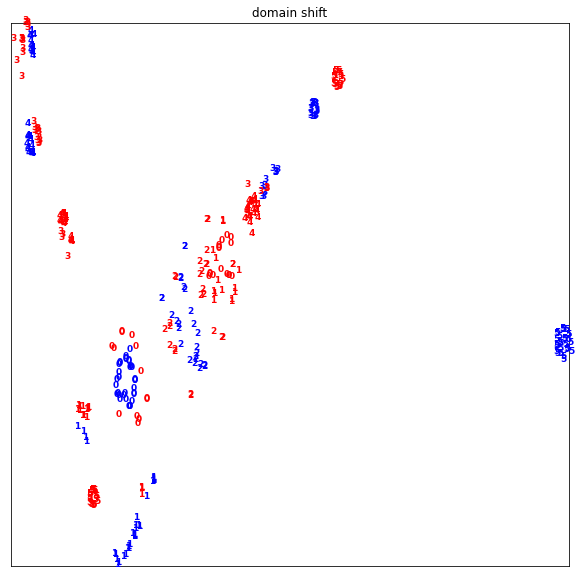

In [0]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
test_tsne = tsne.fit_transform(combined_feat)
plot_embedding(test_tsne, combined_y.argmax(1), combined_domain.argmax(1), 'domain shift')

In [0]:
trans_feat = transfered_features.numpy().reshape(transfered_features.numpy().shape[0], -1)
combined_feat = np.vstack([s_feat, trans_feat])
combined_y = np.vstack([s_y, t_y])
combined_domain = np.vstack([np.tile([1., 0.], [s_feat.shape[0], 1]),
        np.tile([0., 1.], [trans_feat.shape[0], 1])])

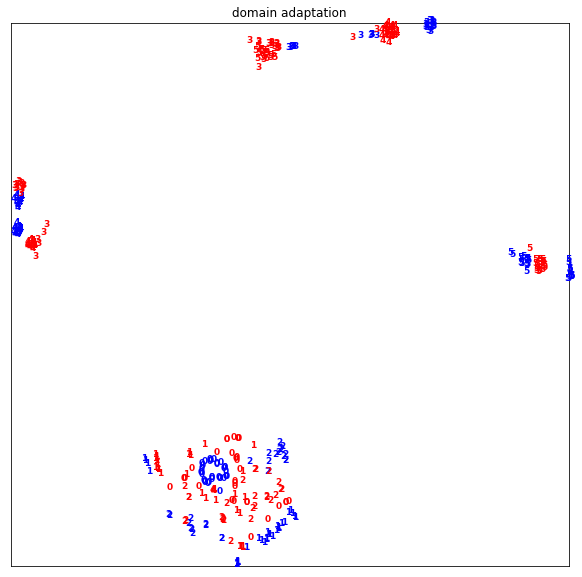

In [0]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
test_tsne = tsne.fit_transform(combined_feat)
plot_embedding(test_tsne, combined_y.argmax(1), combined_domain.argmax(1), 'domain adaptation')

source2target

In [0]:
source_x_test = source_data['data_x_test']
transfered_source_x_test = generator_s2t(source_x_test)
source_y_test = tf.one_hot(source_data['data_y_test'], 6)
_, acc = target_classifier.evaluate(transfered_source_x_test, source_y_test, batch_size=4)

16/16 [==============================] - 0s 7ms/step - loss: 3.0886 - accuracy: 0.4531


In [0]:
source_y_test_pred = target_classifier.predict(transfered_source_x_test)
conf_mat = confusion_matrix(source_y_test.numpy().argmax(axis=1), source_y_test_pred.argmax(axis=1))
print(conf_mat)

[[ 7  0  5  0  0  0]
 [ 4  0  7  0  0  0]
 [ 4  1  4  0  0  0]
 [ 1  0  0  6  4  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0  0 12]]


In [0]:
source_x_train = source_data['data_x_train']
transfered_source_x_train = generator_s2t(source_x_train)
s_y = tf.one_hot(source_data['data_y_train'], 6)
t_y = tf.one_hot(target_data['data_y_train'], 6)

In [0]:
extractor = tf.keras.Model(inputs=target_classifier.input, outputs=[layer.output for layer in target_classifier.layers])
s_features = extractor(source_data['data_x_train'])[-8]
t_features = extractor(target_data['data_x_train'])[-8]
transfered_features = extractor(transfered_source_x_train)[-8]

In [0]:
s_feat = s_features.numpy().reshape(s_features.numpy().shape[0], -1)
t_feat = t_features.numpy().reshape(t_features.numpy().shape[0], -1)
combined_feat = np.vstack([s_feat, t_feat])
combined_y = np.vstack([s_y, t_y])
combined_domain = np.vstack([np.tile([1., 0.], [s_feat.shape[0], 1]),
        np.tile([0., 1.], [t_feat.shape[0], 1])])

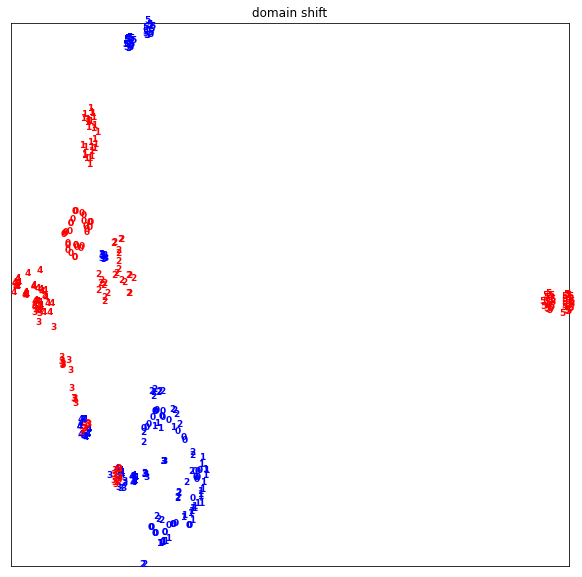

In [0]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
test_tsne = tsne.fit_transform(combined_feat)
plot_embedding(test_tsne, combined_y.argmax(1), combined_domain.argmax(1), 'domain shift')

In [0]:
trans_feat = transfered_features.numpy().reshape(transfered_features.numpy().shape[0], -1)
combined_feat = np.vstack([trans_feat, t_feat])
combined_y = np.vstack([s_y, t_y])
combined_domain = np.vstack([np.tile([1., 0.], [trans_feat.shape[0], 1]),
        np.tile([0., 1.], [t_feat.shape[0], 1])])

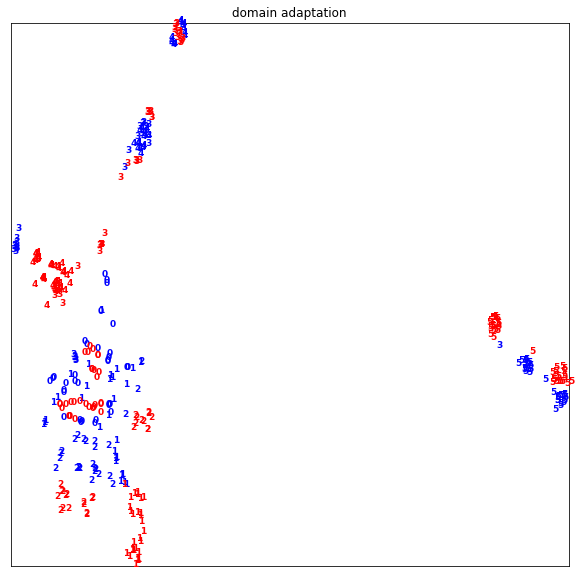

In [0]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
test_tsne = tsne.fit_transform(combined_feat)
plot_embedding(test_tsne, combined_y.argmax(1), combined_domain.argmax(1), 'domain adaptation')